# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection 
import plotly.express as px

from matplotlib import pyplot as plt
from IPython.display import HTML
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics


## 0.1 Helper Functions

### Set Display

In [2]:
def notebook_settings():

    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option( 'display.expand_frame_repr', False)

    sns.set()
notebook_settings()

## 0.2 Load Data

In [3]:
data = pd.read_csv('../data/raw/data.csv', encoding='unicode_escape')

# Planification (IoT)

# 1.0 Data Description

### 1.1 Data Dimensions

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.2 Rename Columns

In [6]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x ) # change to snakecase
cols_new = list( map( snakecase, cols_old ))

data.columns = cols_new # define the new columns

### 1.3 Check and fillout Nan

In [7]:
# check Na
data.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [8]:
# drop Na
data = data.dropna()

### 1.4 Change dtypes

In [9]:
# invoice data to datetime
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

### 1.5 Descriptive Statistics

#### Numerical

In [10]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
quantity,406829.0,12.061303,-80995.0,2.0,5.0,12.0,80995.0,248.69337
invoice_date,406829,2011-07-10 16:30:57.879207424,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-31 11:48:00,2011-10-20 13:06:00,2011-12-09 12:50:00,NaN
unit_price,406829.0,3.460471,0.0,1.25,1.95,3.75,38970.0,69.315162
customer_id,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


#### Categorical

In [11]:
data.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

# 2.0 Feature Engineering

In [12]:
df1 = data.copy()

In [13]:
# filter only customer_id column
df_ref = df1['customer_id'].drop_duplicates( ignore_index=True)

# revenue
df1['revenue'] = df1['unit_price'] * df1['quantity']

# Monetary
ref = df1[['customer_id', 'revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, ref, on='customer_id', how='left')

# recency
recency = df1[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
recency['recency_days'] = (df1['invoice_date'].max() -  recency['invoice_date']).dt.days
recency = recency[['customer_id', 'recency_days']]
df_ref = pd.merge(df_ref, recency, on='customer_id', how='left')

# frequency
frequency = df1[['invoice_no', 'customer_id']].drop_duplicates().groupby('customer_id').count().reset_index()
frequency.columns = ['customer_id', 'frequency']
df_ref = pd.merge(df_ref, frequency, on='customer_id', how='left')

In [14]:
df_ref.head()

,customer_id,revenue,recency_days,frequency
0,17850.0,5288.63,301,35
1,13047.0,3079.10,31,18
2,12583.0,7187.34,2,18
3,13748.0,948.25,95,5
4,15100.0,635.10,329,6


# 3.0 Data Filtering

# 4.0 EDA

## 4.1 Hypothesis Map

## 4.2 Univariate Analysis

# 5.0 Data Preparation

### Standardization, Rescaling and Encoding

# 6.0 Feature Selection

## 6.1 Split Train & Validation

## 6.2 Fature Selection

### Boruta

### Fature Importance

# 7.0 Hyperparameter Fine-Tunning

In [15]:
df2 = df_ref.copy()

In [16]:
X = df2.drop( columns=['customer_id'] )

In [17]:
cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10]

### Within-Cluster Sum of Squares (WSS)

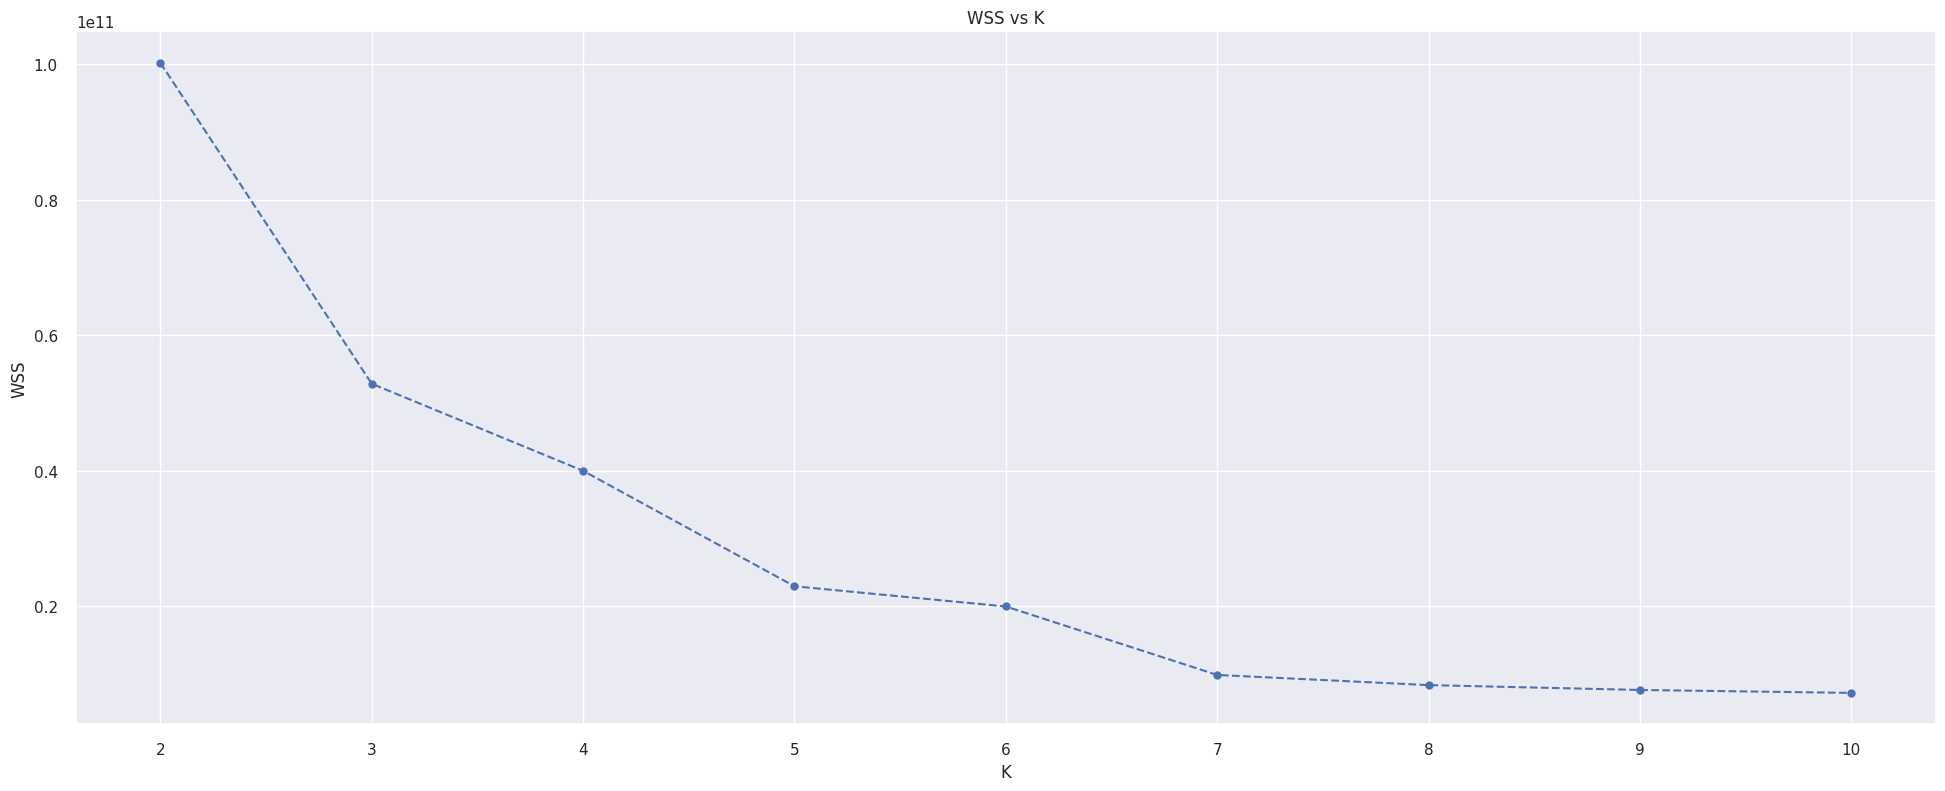

In [18]:
wss = []
for k in cluster:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10,  max_iter=300, random_state=42)

    # model training
    kmeans.fit( X )

    #validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method
plt.plot(cluster, wss, linestyle='--', marker='o');
plt.xlabel( 'K' );
plt.ylabel( 'WSS' );
plt.title('WSS vs K');

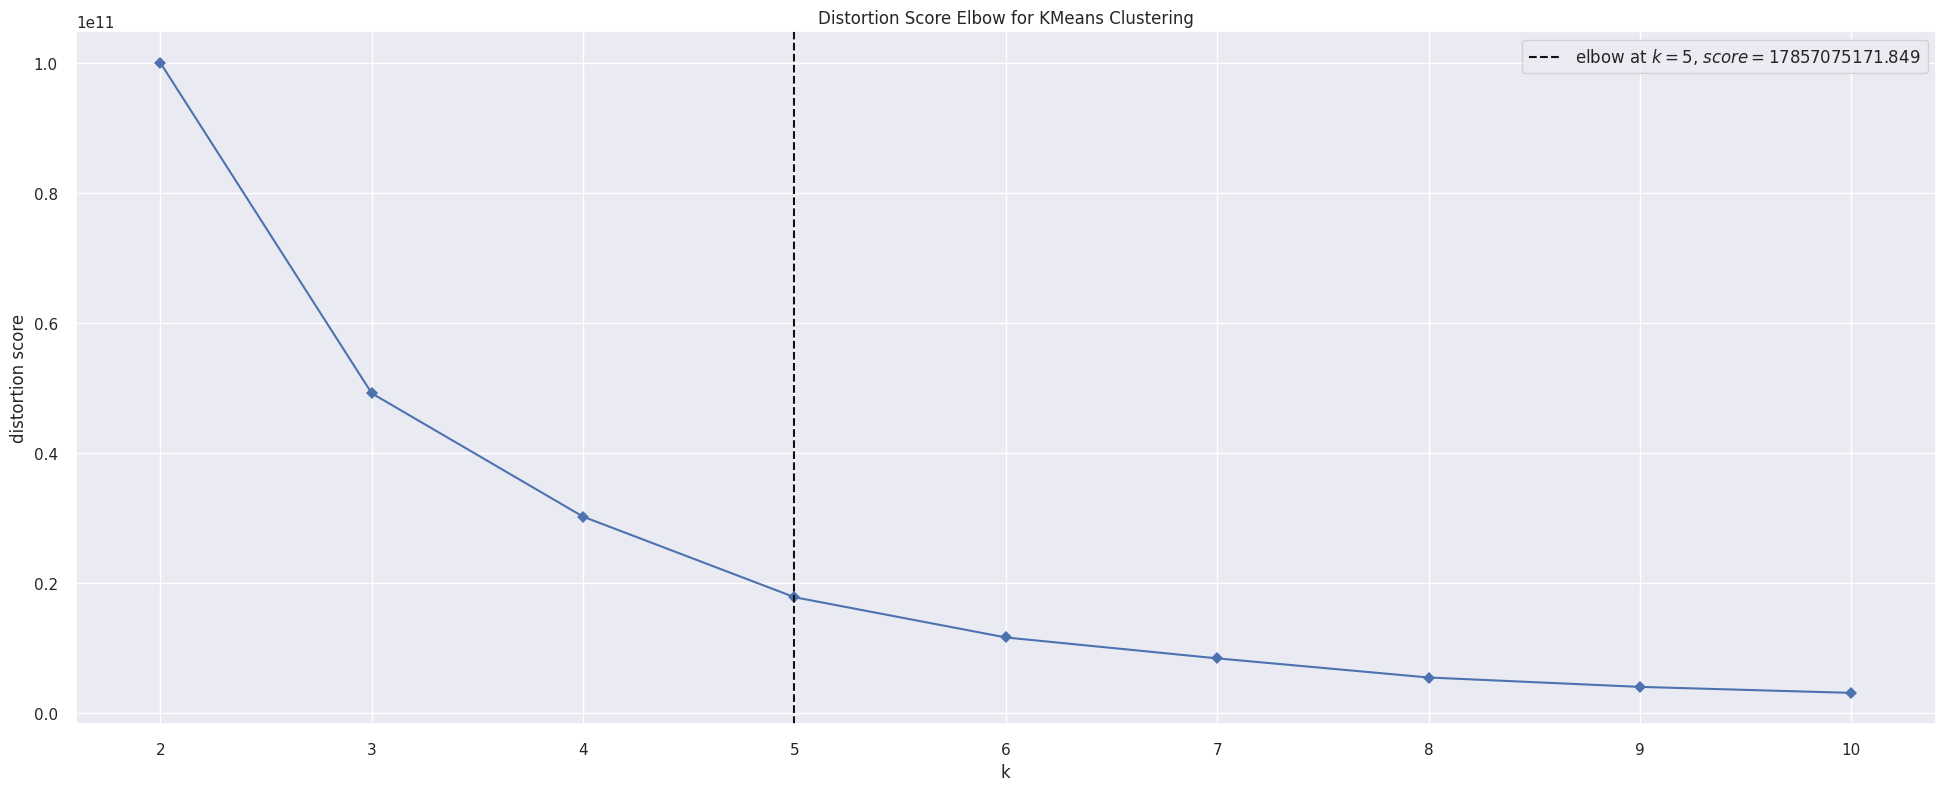

In [19]:
kmeans = KElbowVisualizer( KMeans(n_init=10), k=cluster, timings=False)
kmeans.fit( X );
kmeans.show();

### Silhouette Score

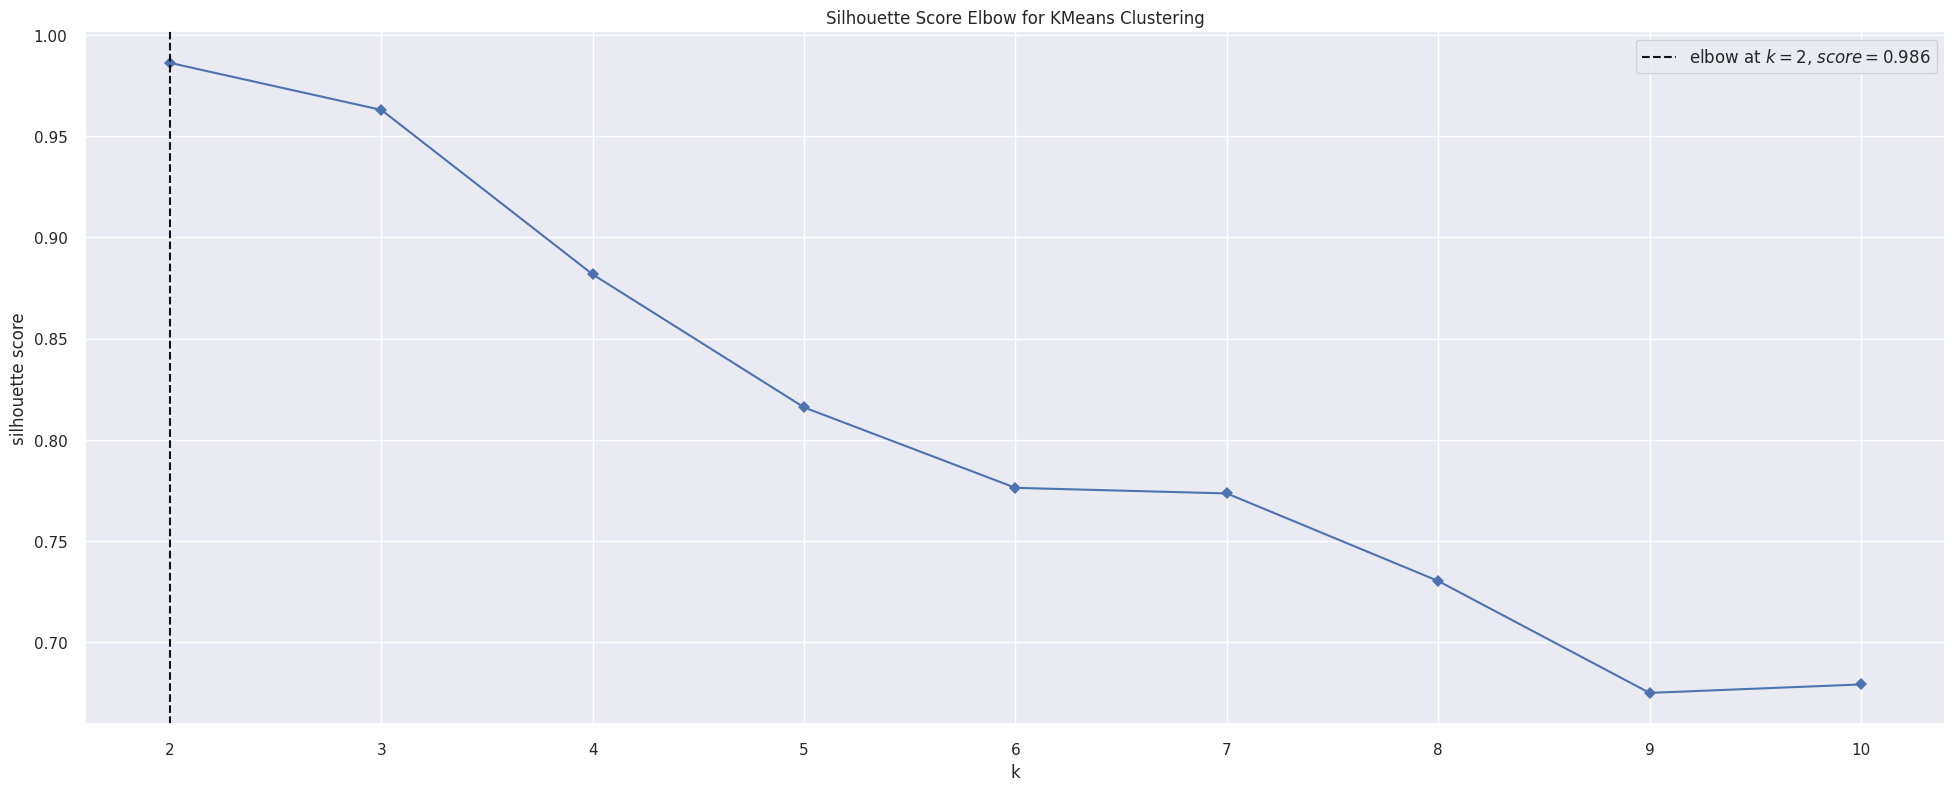

In [20]:
kmenas = KElbowVisualizer( KMeans(n_init=10), k=cluster, metric='silhouette', timings=False);
kmenas.fit( X );
kmenas.show();

# 8.0 Machine Learnign Modeling

In [21]:
# model definition
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model trainig 
kmeans.fit ( X )

# clustering
labels = kmeans.labels_

### Cluster Validation

In [22]:
# WSS 
print( f'WSS value: {kmeans.inertia_}')

# Silhouette
print(f'SS Value: {metrics.silhouette_score( X, labels, metric="euclidean")}')

WSS value: 52830436382.665115


SS Value: 0.9494677108004962


# 9.0 Cluster Analysis

In [23]:
df3 = df_ref.copy()
df3['cluster'] = labels

In [24]:
df3.head()

,customer_id,revenue,recency_days,frequency,cluster
0,17850.0,5288.63,301,35,0
1,13047.0,3079.10,31,18,0
2,12583.0,7187.34,2,18,0
3,13748.0,948.25,95,5,0
4,15100.0,635.10,329,6,0


### Visualization Inspection

In [26]:
fig = px.scatter_3d(df3, x='recency_days', y='frequency', z='revenue', color='cluster')
fig.show()

### Cluster Profile

In [39]:
# Number of customers
df_cluster = df3[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['per_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg revenue
df_avg_revenue = df3[['revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, on='cluster', how='inner')

# Avg recency
df_avg_recency = df3[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster', how='inner')

# Avg frequency
df_avg_frequency = df3[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster', how='inner')

In [ ]:
# Cluster 1: (Insider)
- Nº Customers: 6 (0.13%)
- Avg Recency: 7 days
- Avg Revenue: $182.182,00
- Avg Frequency: 89

# Cluster 2:
- Nº Customers: 31 (0.71%)
- Avg Recency: 12 days
- Avg Revenue: $40.543,00
- Avg Frequency: 53

# Cluster 2:
- Nº Customers: 4335 (99.15%)
- Avg Recency: 92 days
- Avg Revenue: $1.372,00
- Avg Frequency: 5P

# 10.0 Deploy